In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import category_encoders as ce

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
import random
import xgboost as xgb

In [2]:
datos = pd.read_csv('events_up_to_01062018.csv')
tabla_completa = datos.copy()
res = pd.read_csv('labels_training_set.csv');

C:\Users\Santi\AppData\Roaming\Python\Python36\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
tabla_completa['aux']=1
#Voy a contar la cantidad para cada tipo de evento de cada persona
num_eventos = tabla_completa.groupby(['person','event'])['aux'].sum()

num_eventos = num_eventos.unstack().reset_index().fillna(0)
num_eventos = num_eventos.set_index('person')
num_eventos['total_eventos'] = num_eventos.sum(axis=1)
#normalizo los numeros obtenidos según la cantidad de eventos totales de esa persona
num_eventos_norm = num_eventos.loc[:,"ad campaign hit":"visited site"].div(num_eventos["total_eventos"], axis=0)
num_eventos_norm = num_eventos_norm.reset_index()
num_eventos_norm.head()

tabla_completa['timestamp'] = pd.to_datetime(tabla_completa['timestamp'])
#tabla_completa['timestamp'].max() -tabla_completa['timestamp'].min()

time_for_user = tabla_completa.groupby(['person'])['timestamp'].apply(lambda x: x.max() - x.min())
time_for_user = time_for_user.reset_index()
time_for_user['total_horas'] = time_for_user['timestamp'].dt.total_seconds()/3600
time_for_user = time_for_user.drop(['timestamp'],axis='columns')

max_time = tabla_completa.groupby(['person'])['timestamp'].apply(lambda x: x.max())
max_time = max_time.reset_index()
max_time['max'] = max_time['timestamp'].dt.month
max_time = max_time.drop(['timestamp'],axis='columns')

time_for_user = pd.merge(max_time,time_for_user,on='person',how='inner')

min_time = tabla_completa.groupby(['person'])['timestamp'].apply(lambda x: x.min())
min_time = min_time.reset_index()
min_time['min'] = min_time['timestamp'].dt.month
min_time = min_time.drop(['timestamp'],axis='columns')

time_for_user = pd.merge(min_time,time_for_user,on='person',how='inner')

num_eventos_norm = num_eventos_norm.reset_index()
num_eventos = num_eventos.reset_index()
total_eventos = pd.merge(num_eventos,num_eventos_norm, on='person',how='inner')
total_eventos = pd.merge(total_eventos,time_for_user,on='person',how='inner')

In [4]:
total_eventos.shape

(38829, 28)

In [5]:
tabla_encode = datos.copy()
tabla_encode.head()

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
0,2018-05-18 00:11:59,viewed product,4886f805,NaN,9288.0,Samsung Galaxy J7 Prime,Excelente,32GB,Dourado,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-05-18 00:11:27,viewed product,ad93850f,NaN,304.0,iPhone 5s,Muito Bom,32GB,Cinza espacial,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-05-18 00:11:16,viewed product,0297fc1e,NaN,6888.0,iPhone 6S,Muito Bom,64GB,Prateado,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-05-18 00:11:14,viewed product,2d681dd8,NaN,11890.0,iPhone 7,Bom,128GB,Vermelho,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-05-18 00:11:09,viewed product,cccea85e,NaN,7517.0,LG G4 H818P,Excelente,32GB,Branco,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
tabla_encode = tabla_encode.fillna(0)

In [7]:
#device_type
tabla_encode.groupby('device_type')['person'].count()
#0 no cuenta (es que no hay evento)
#son solo 4 tipos distintos, así que los mantengo todos

device_type
0             2137612
Computer        97485
Smartphone     103502
Tablet           2799
Unknown           283
Name: person, dtype: int64

In [8]:
dev_type = tabla_encode[['person','device_type']]
dev_type['aux'] = 1
dev_type = dev_type.groupby(['person','device_type'])['aux'].count().unstack().reset_index().fillna(0)
dev_type = dev_type.drop([0],axis=1)
dev_type = dev_type.set_index('person')
dev_type = dev_type.add_prefix('device_type_')
dev_type = dev_type.reset_index()
dev_type.shape

C:\Users\Santi\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(38829, 5)

In [9]:
#device_type
tabla_encode.groupby('browser_version')['person'].count().sort_values(ascending=False)
#0 no cuenta (es que no hay evento)
#son 367 tipos distintos. Voy a vovler a mirar, pero uniendo por versiones

browser_version
0                                  2137612
Chrome 66.0                          57953
Chrome Mobile 66.0                   45589
Chrome Mobile 65.0                   15542
Chrome 65.0                          14920
Chrome Mobile 64.0                    7787
Chrome 64.0                           5670
Mobile Safari 11                      4501
Chrome 63.0                           4358
Chrome Mobile 63.0                    4217
Samsung Internet 6.4                  2884
Firefox 59                            2589
Firefox 60                            2298
Chrome Mobile 39                      2042
Mobile Safari 10                      1970
Edge 16.16299                         1574
Chrome Mobile 55.0                    1549
Chrome Mobile 43.0                    1266
Chrome 49.0                           1028
IE 11                                  999
Chrome Mobile 62.0                     891
Samsung Internet 3.3                   820
Chrome 67.0                           

In [10]:
test_b = tabla_encode['browser_version'].str.replace('\d+', '')
test_b = test_b.str.replace('.', '')
test_b = test_b.str.strip()
test_b2 = pd.DataFrame(test_b)
test_b2['aux']=1
test_b2 = test_b2.groupby('browser_version').count().reset_index().sort_values(by='aux',ascending=False)
#Ahora me quedan 30 browsers. Voy a quedarme con los 5 más usados. El resto irá a una columna "otros".
browsers = test_b2['browser_version'].head()
browsers

3               Chrome
4        Chrome Mobile
16       Mobile Safari
10             Firefox
25    Samsung Internet
Name: browser_version, dtype: object

In [11]:
browser_version = tabla_encode[['person','browser_version']]
browser_version['aux'] = 1
browser_version = browser_version.groupby(['person','browser_version'])['aux'].count().unstack().reset_index().fillna(0)
browser_version = browser_version.drop([0],axis=1)
browser_version = browser_version.set_index('person')
browser_version = browser_version.add_prefix('browser_version_')
browser_version = browser_version.reset_index()
browser_version.shape


C:\Users\Santi\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(38829, 367)

In [12]:
#screen_resolution
test_s = tabla_encode['screen_resolution']
test_s = pd.DataFrame(test_s)
test_s['aux']=1
test_s = test_s.groupby('screen_resolution').count().reset_index().sort_values(by='aux',ascending=False)
test_s = test_s.drop([0],axis=0)

resolutions = test_s['screen_resolution'].head()
resolutions
#Me quedo con las 5 resoluciones que mas buscan

241      360x640
83      1366x768
150    1920x1080
220      320x534
79      1360x768
Name: screen_resolution, dtype: object

In [13]:
screen_resolution = tabla_encode[['person','screen_resolution']]
screen_resolution['aux'] = 1
screen_resolution = screen_resolution.groupby(['person','screen_resolution'])['aux'].count().unstack().reset_index().fillna(0)
screen_resolution = screen_resolution.drop([0],axis=1)
screen_resolution = screen_resolution.set_index('person')
screen_resolution = screen_resolution.add_prefix('screen_resolution_')
screen_resolution = screen_resolution.reset_index()
screen_resolution.shape


C:\Users\Santi\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(38829, 394)

In [14]:
#operating_system_version
test_os = tabla_encode['operating_system_version'].str.replace('\d+', '')
test_os = test_os.str.replace('.', '')
test_os = test_os.str.strip()
test_os2 = pd.DataFrame(test_os)
test_os2['aux']=1
test_os2 = test_os2.groupby('operating_system_version').count().reset_index().sort_values(by='aux',ascending=False)
test_os2

OSs = test_os2['operating_system_version'].head()
OSs
#Me quedo con las 5 resoluciones que mas buscan

0           Android
11          Windows
16              iOS
15       Windows XP
12    Windows Phone
Name: operating_system_version, dtype: object

In [15]:
operating_system_version = tabla_encode[['person','operating_system_version']]
operating_system_version['aux'] = 1
operating_system_version = operating_system_version.groupby(['person','operating_system_version'])['aux'].count().unstack().reset_index().fillna(0)
operating_system_version = operating_system_version.drop([0],axis=1)
operating_system_version = operating_system_version.set_index('person')
operating_system_version = operating_system_version.add_prefix('operating_system_version_')
operating_system_version = operating_system_version.reset_index()
operating_system_version.shape


C:\Users\Santi\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(38829, 132)

In [16]:
#storage
test_st = tabla_encode['storage']
test_st = pd.DataFrame(test_st)
test_st['aux']=1
test_st = test_st.groupby('storage').count().reset_index().sort_values(by='aux',ascending=False)
test_st = test_st.drop([0],axis=0)

storages = test_st['storage'].head()
storages
#Me quedo con las 5 resoluciones que mas buscan

2     16GB
4     32GB
7     64GB
1    128GB
8      8GB
Name: storage, dtype: object

In [17]:
storage = tabla_encode[['person','storage']]
storage['aux'] = 1
storage = storage.groupby(['person','storage'])['aux'].count().unstack().reset_index().fillna(0)
storage = storage.drop([0],axis=1)
storage = storage.set_index('person')
storage = storage.add_prefix('storage_')
storage = storage.reset_index()
storage.shape


C:\Users\Santi\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(38829, 9)

In [18]:
#condition
test_c = tabla_encode['condition']
test_c = pd.DataFrame(test_c)
test_c['aux']=1
test_c = test_c.groupby('condition').count().reset_index().sort_values(by='aux',ascending=False)
test_c = test_c.drop([0],axis=0)
test_c

#Ya son 5, me quedo todas.

,condition,aux
1,Bom,547617
3,Excelente,378697
4,Muito Bom,359053
2,Bom - Sem Touch ID,31742
5,Novo,3421


In [19]:
condition = tabla_encode[['person','condition']]
condition['aux'] = 1
condition = condition.groupby(['person','condition'])['aux'].count().unstack().reset_index().fillna(0)
condition = condition.drop([0],axis=1)
condition = condition.set_index('person')
condition = condition.add_prefix('condition_')
condition = condition.reset_index()
condition.shape

C:\Users\Santi\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(38829, 6)

In [20]:
#new_vs_returning
test_nv = tabla_encode['new_vs_returning']
test_nv = pd.DataFrame(test_nv)
test_nv['aux']=1
test_nv = test_nv.groupby('new_vs_returning').count().reset_index().sort_values(by='aux',ascending=False)
test_nv = test_nv.drop([0],axis=0)
test_nv
#Son solo 2 valores

,new_vs_returning,aux
2,Returning,165827
1,New,38242


In [21]:
#Esta la hago un count.
new_vs_returning = tabla_encode[['person','new_vs_returning']]
new_vs_returning['aux'] = 1
new_vs_returning = new_vs_returning.groupby(['person','new_vs_returning'])['aux'].count().unstack().reset_index().fillna(0)
new_vs_returning = new_vs_returning.drop([0],axis=1)
new_vs_returning = new_vs_returning.set_index('person')
new_vs_returning = new_vs_returning.add_prefix('new_vs_returning_')
new_vs_returning = new_vs_returning.reset_index()
new_vs_returning.shape

C:\Users\Santi\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(38829, 3)

In [22]:
#search_engine
test_se = tabla_encode['search_engine']
test_se = pd.DataFrame(test_se)
test_se['aux']=1
test_se = test_se.groupby('search_engine').count().reset_index().sort_values(by='aux',ascending=False)
test_se = test_se.drop([0],axis=0)
test_se
#Son solo 4 valores

,search_engine,aux
3,Google,105195
2,Bing,676
4,Yahoo,519
1,Ask,16


In [23]:
#Esta la hago un count.
search_engine = tabla_encode[['person','search_engine']]
search_engine['aux'] = 1
search_engine = search_engine.groupby(['person','search_engine'])['aux'].count().unstack().reset_index().fillna(0)
search_engine = search_engine.drop([0],axis=1)
search_engine = search_engine.set_index('person')
search_engine = search_engine.add_prefix('search_engine_')
search_engine = search_engine.reset_index()
search_engine.shape

C:\Users\Santi\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(38829, 5)

In [24]:
#channel
test_ch = tabla_encode['channel']
test_ch = pd.DataFrame(test_ch)
test_ch['aux']=1
test_ch = test_ch.groupby('channel').count().reset_index().sort_values(by='aux',ascending=False)
test_ch = test_ch.drop([0],axis=0)
test_ch
#Mantengo los 7 valores

,channel,aux
4,Paid,91753
1,Direct,50675
5,Referral,33990
3,Organic,25867
6,Social,1406
2,Email,371
7,Unknown,7


In [25]:
#Esta la hago un count.
channel = tabla_encode[['person','channel']]
channel['aux'] = 1
channel = channel.groupby(['person','channel'])['aux'].count().unstack().reset_index().fillna(0)
channel = channel.drop([0],axis=1)
channel = channel.set_index('person')
channel = channel.add_prefix('channel_')
channel = channel.reset_index()
channel.shape

C:\Users\Santi\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(38829, 8)

In [26]:
#Ahora a unir todo...

In [27]:
tabla_final = pd.merge(total_eventos,dev_type,on='person',how='inner')
tabla_final = pd.merge(tabla_final,screen_resolution,on='person',how='inner')
tabla_final = pd.merge(tabla_final,storage,on='person',how='inner')
tabla_final = pd.merge(tabla_final,condition,on='person',how='inner')
tabla_final = pd.merge(tabla_final,new_vs_returning,on='person',how='inner')
tabla_final = pd.merge(tabla_final,search_engine,on='person',how='inner')
tabla_final = pd.merge(tabla_final,channel,on='person',how='inner')
tabla_final = pd.merge(tabla_final,browser_version,on='person',how='left')
tabla_final = pd.merge(tabla_final,operating_system_version,on='person',how='left')
tabla_final = tabla_final.fillna(0)
tabla_final.shape

(38829, 948)

In [28]:
tabla_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38829 entries, 0 to 38828
Columns: 948 entries, person to operating_system_version_iOS 9.3.5
dtypes: float64(944), int64(3), object(1)
memory usage: 281.1+ MB


In [29]:

intento_f = pd.merge(tabla_final,res,on='person',how='inner')

intento_f = intento_f.set_index('person')

In [30]:
final = pd.read_csv('trocafone_kaggle_test.csv')
final = pd.merge(tabla_final,final,on='person',how='inner')
final = final.set_index('person')
x_entrega = final

In [31]:
#XGBoost

X, y = intento_f.iloc[:,:-1],intento_f.iloc[:,-1]
data_dmatrix = xgb.DMatrix(data=X,label=y)


In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=123)
    
xg_reg = xgb.XGBRegressor(objective ='reg:linear', 
                colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 2, n_estimators = 10)

model = xg_reg.fit(X_train,y_train)
model.feature_importances_

array([0.025     , 0.01666667, 0.02083333, 0.02916667, 0.00833333,
       0.        , 0.01666667, 0.00833333, 0.00416667, 0.02083333,
       0.00833333, 0.03333334, 0.04583333, 0.01666667, 0.00833333,
       0.025     , 0.03333334, 0.        , 0.        , 0.00833333,
       0.00416667, 0.00416667, 0.05416667, 0.01666667, 0.01666667,
       0.00833333, 0.03333334, 0.03333334, 0.00833333, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [33]:
selection = SelectFromModel(model, threshold=0, prefit=True)
select_X_train = selection.transform(X_train)
select_X_test = selection.transform(X_test)

xg_reg.fit(select_X_train,y_train)


NameError: name 'SelectFromModel' is not defined

<function matplotlib.pyplot.show>

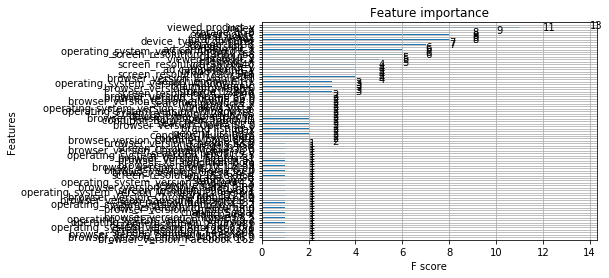

In [39]:
# plot feature importance using built-in function
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

# plot feature importance
plot_importance(model)
pyplot.show

In [ ]:
from numpy import loadtxt
from numpy import sort
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
# load data

# make predictions for test data and evaluate
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds = [0,1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

In [ ]:
preds = xg_reg.predict(select_X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

In [ ]:

entrega = xg_reg.predict(x_entrega)
entrega = entrega.clip(min=0)  

y_summit = pd.DataFrame(entrega)
y_summit.columns = ['label']
y_summit['person'] = x_entrega.reset_index()['person']
y_person = x_entrega.reset_index()['person']

y_summit = y_summit[['person','label']]
y_summit.to_csv('summit028.csv', index=False)